# MedicAI + MedMNIST

**About MedMNIST**: [MedMNIST](https://medmnist.com/), a large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D. It has larger sizes: `64x64`, `128x128`, and `224x224` for 2D, and `64x64x64` for 3D.

**About MedicAI**: [Medic-AI](https://github.com/innat/medic-ai) is a Keras based library designed for medical 2D and 3D image analysis using machine learning techniques. It supports multiple backends, i.e. `tensorflow`, `torch`, as well as `jax`, and compatible to run on **Multi-GPU** and **TPU** devices.

---

In this notebook, we are going to cover:

- Load the Blood Cell Microscope dataset from **MedMNIST**, an `8`-class classification dataset.
- Build a data loader using the `tf.data` API.
- Construct a model with **MedicAI**.
- Train the model using the Keras 3 training API.
- Compute **GradCAM** visualizations using MedicAI.

In [1]:
!pip install git+https://github.com/innat/MedMNIST.git -q
!pip install git+https://github.com/innat/medic-ai.git -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow" # tensorflow, torch, jax
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import keras

import medmnist
from medmnist import INFO

from medicai.utils import GradCAM
from medicai.models import EfficientNetV2B0

import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt

print(
    f"keras backend: {keras.config.backend()}\n"
    f"keras version: {keras.version()}\n"
    f"tensorflow version: {tf.__version__}\n"
)

E0000 00:00:1761971228.674298      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761971228.730875      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


keras backend: tensorflow
keras version: 3.8.0
tensorflow version: 2.18.0



In [3]:
# reproducibility
keras.utils.set_random_seed(101)

# Get Data 

In [4]:
input_size = 224
data_flag = 'bloodmnist'

info = INFO[data_flag]
task = info['task']
label_map = info['label']

download = True
DataClass = getattr(medmnist, info['python_class'])

output_root = os.path.join("./", data_flag)
os.makedirs(output_root, exist_ok=True)

_ = DataClass(split="train", root=output_root, size=input_size, download=True)

# print(os.listdir(output_root))
# print(info['description'])
# print(info['n_samples'])
# print(info['license'])
# print(label_map)

100%|██████████| 1.54G/1.54G [01:32<00:00, 16.6MB/s] 


In [5]:
npz_file = np.load(os.path.join(output_root, "{}_{}.npz".format(data_flag,input_size)))
x_train = npz_file['train_images']
y_train = npz_file['train_labels']
x_val = npz_file['val_images']
y_val = npz_file['val_labels']
x_test = npz_file['test_images']
y_test = npz_file['test_labels']

print('Train set ', x_train.shape, y_train.shape)
print('Val set ', x_val.shape, y_val.shape)
print('Test set ', x_test.shape, y_test.shape)

Train set  (11959, 224, 224, 3) (11959, 1)
Val set  (1712, 224, 224, 3) (1712, 1)
Test set  (3421, 224, 224, 3) (3421, 1)


# Data Loader

- Augmentation
- Loader Pipeline

In [6]:
# Define augmentation layers
aug_layers = [
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2, fill_mode="nearest"),
    keras.layers.RandomZoom(0.2, fill_mode="nearest"),
    keras.layers.RandomCrop(
        int(input_size // 1.5),
        int(input_size // 1.5)
    ),
]

def augment_data(x, y):
    for layer in aug_layers:
        x = layer(x)
    x = keras.layers.Resizing(
        input_size, input_size, interpolation="bilinear"
    )(x)
    y = tf.cast(
        tf.cast(y, tf.int32), tf.float32
    )
    return x, y

I0000 00:00:1761971391.025010      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761971391.025746      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:
def get_tf_dataset(x, y, batch_size=32, shuffle=True, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((x, y))

    if shuffle:
        ds = ds.shuffle(buffer_size=min(1000, len(x)))

    ds = ds.batch(batch_size, drop_remainder=augment)

    if augment:
        ds = ds.map(
            augment_data, num_parallel_calls=tf.data.AUTOTUNE
        )

    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [8]:
train_ds = get_tf_dataset(
    x_train, y_train, shuffle=True, augment=True
)

val_ds = get_tf_dataset(
    x_val, y_val, shuffle=False
)

test_ds = get_tf_dataset(
    x_test, y_test, shuffle=False
)

In [9]:
def plot_dataset_samples(dataset, class_ids=None, n=9):
    plt.figure(figsize=(10, 10))
    
    for i, (images, labels) in enumerate(dataset.unbatch().take(n)):
        ax = plt.subplot(int(n ** 0.5 + 0.5), int(n ** 0.5 + 0.5), i + 1)
        img = images.numpy()
        lbl = labels.numpy()

        # handle grayscale or float images
        if img.ndim == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img.astype("uint8"))

        plt.title(label_map[str(class_ids)])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

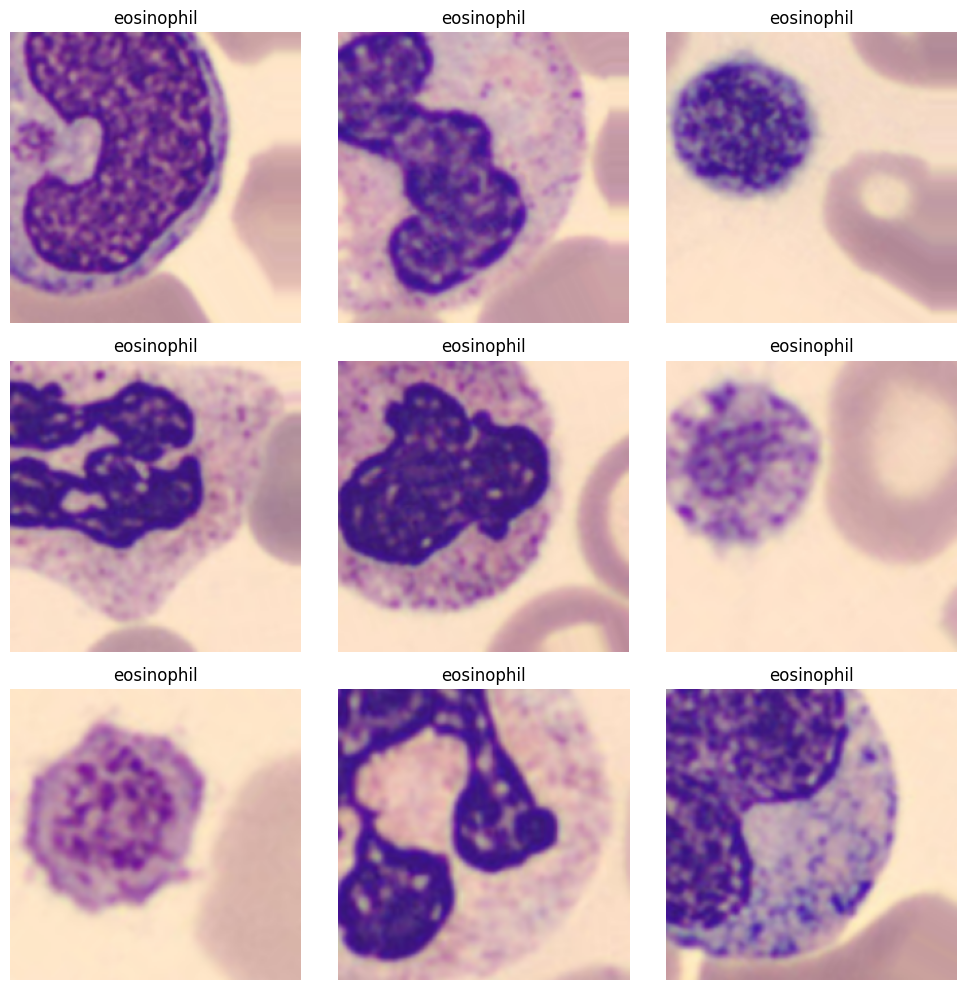

In [10]:
# print(label_map)
plot_dataset_samples(train_ds, class_ids=1, n=9)

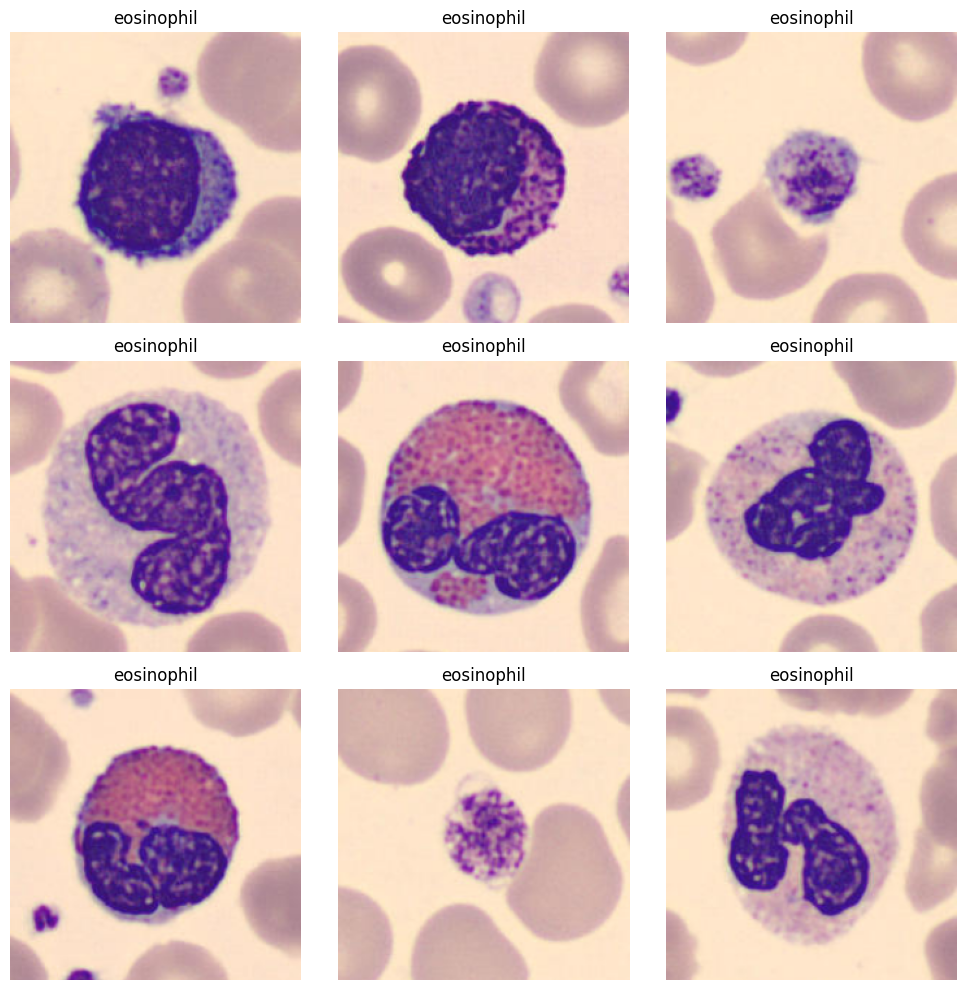

In [11]:
plot_dataset_samples(val_ds, class_ids=1, n=9)

# Model

In [12]:
model = EfficientNetV2B0(
    input_shape=(
        input_size, input_size, 3
    ),
    include_top=True,
    classifier_activation='softmax',
    num_classes=len(label_map),
)
# model.summary(line_length=100)
model.count_params() / 1e6

5.92956

**compile**

In [13]:
# define optomizer, loss, metrics
optim = keras.optimizers.AdamW(
    learning_rate=1e-4,
    weight_decay=1e-5,
)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False, name='loss')
metrics = [
    keras.metrics.SparseCategoricalAccuracy(name='acc'),
]

# compile keras model with defined optimozer, loss and metrics
model.compile(
    optimizer=optim,
    loss=loss_fn,
    metrics=metrics
)

# Training

In [14]:
model_ckpt_callback = keras.callbacks.ModelCheckpoint(
    filepath='model.weights.h5', 
    save_freq='epoch', 
    verbose=0, 
    monitor='val_loss', 
    save_weights_only=True, 
    save_best_only=True
)   


model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[model_ckpt_callback],
    epochs=50
)

Epoch 1/50


I0000 00:00:1761971582.225969     193 service.cc:148] XLA service 0x7d1f0c003270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761971582.226911     193 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761971582.226943     193 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761971587.636312     193 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1761971598.295286     193 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761971598.434248     193 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1761971620.196915     193 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most onc

373/373 ━━━━━━━━━━━━━━━━━━━━ 163s 168ms/step - acc: 0.3942 - loss: 2.0771 - val_acc: 0.5070 - val_loss: 2.1215
Epoch 2/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 53s 141ms/step - acc: 0.7526 - loss: 0.7596 - val_acc: 0.7027 - val_loss: 0.9620
Epoch 3/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 53s 140ms/step - acc: 0.8257 - loss: 0.5187 - val_acc: 0.7961 - val_loss: 0.5022
Epoch 4/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 52s 139ms/step - acc: 0.8598 - loss: 0.4083 - val_acc: 0.8242 - val_loss: 0.5034
Epoch 5/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 52s 139ms/step - acc: 0.8769 - loss: 0.3574 - val_acc: 0.7915 - val_loss: 0.5576
Epoch 6/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 53s 140ms/step - acc: 0.8849 - loss: 0.3509 - val_acc: 0.8744 - val_loss: 0.3611
Epoch 7/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 51s 136ms/step - acc: 0.8950 - loss: 0.3032 - val_acc: 0.8423 - val_loss: 0.4574
Epoch 8/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 52s 137ms/step - acc: 0.9103 - loss: 0.2583 - val_acc: 0.8154 - val_loss: 0.5195
Epoch 9/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 52

**Evaluation**

In [15]:
model.load_weights('model.weights.h5')
results = model.evaluate(test_ds)
print("test loss, test acc:", results)

107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - acc: 0.9368 - loss: 0.1898
test loss, test acc: [0.1985146850347519, 0.9362759590148926]


# Visualization

- Pick target layers. Inspect `model.layers` to get target layer's name.
- Pick target class index. Inspect `label_map` to select target class.

**utility**

In [29]:
def plot_gradcam_results(model, grad_cam, test_ds, label_map, target_index=0, n=3):
    # Temporarily shuffle dataset
    ds_vis = test_ds.shuffle(buffer_size=2048)
    test_x, test_y = next(iter(ds_vis))
    test_y = test_y.numpy().squeeze()
    test_x = test_x.numpy()

    # Select only samples with the target class
    mask = test_y == target_index
    test_x = test_x[mask]
    test_y = test_y[mask]

    if len(test_x) == 0:
        print(f"No samples with target_index={target_index} in this batch.")
        return

    # Model predictions
    preds = model.predict(test_x, verbose=0)
    pred_classes = preds.argmax(-1)

    # Compute Grad-CAM heatmaps
    heatmaps = grad_cam.compute_heatmap(test_x, target_class_index=target_index)

    # Plot
    n = min(n, len(test_x))
    fig, axes = plt.subplots(n, 3, figsize=(15, 4 * n))
    if n == 1:
        axes = np.expand_dims(axes, 0)

    for i in range(n):
        img = test_x[i]
        heat = heatmaps[i]
        
        gt_label = label_map.get(
            str(int(test_y[i])), str(int(test_y[i]))
        )
        pred_label = label_map.get(
            str(int(pred_classes[i])), str(int(pred_classes[i]))
        )

        # Normalize image for visualization
        img = np.clip(img, 0, 1) if img.max() <= 1 else img.astype(np.uint8)

        # Original
        ax1 = axes[i, 0]
        ax1.imshow(img)
        ax1.set_title(f"GT: {gt_label}\nPred: {pred_label}", fontsize=11, weight='bold')
        ax1.axis("off")

        # Grad-CAM heatmap
        ax2 = axes[i, 1]
        ax2.imshow(heat, cmap='jet')
        ax2.set_title("Grad-CAM", fontsize=11, weight='bold')
        ax2.axis("off")

        # Overlay
        ax3 = axes[i, 2]
        ax3.imshow(img)
        ax3.imshow(heat, cmap='jet', alpha=0.45)
        ax3.set_title("Overlay", fontsize=11, weight='bold')
        ax3.axis("off")

    plt.tight_layout()
    plt.show()


In [25]:
# for layer in model.layers[::-1]:
#     print(layer.name, layer.output.shape)

In [26]:
grad_cam = GradCAM(
    model,
    target_layer='top_activation',
    task_type='auto'
)

In [27]:
label_map

{'0': 'basophil',
 '1': 'eosinophil',
 '2': 'erythroblast',
 '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)',
 '4': 'lymphocyte',
 '5': 'monocyte',
 '6': 'neutrophil',
 '7': 'platelet'}

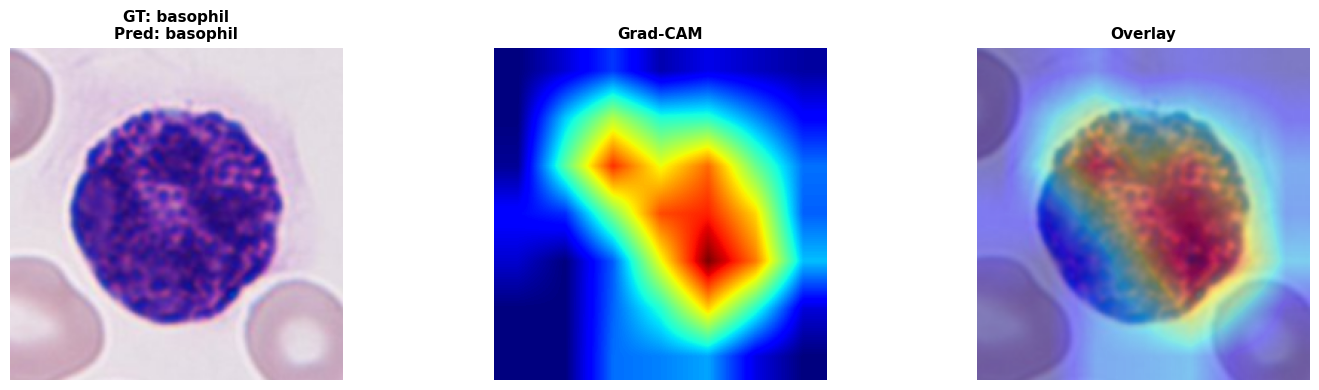

In [32]:
plot_gradcam_results(
    model, grad_cam, test_ds, label_map, target_index=0, n=3
)